In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
if "google.colab" in sys.modules:
    !pip install Levenshtein
    !pip install unidecode
    !pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.2 MB/s 
     |████████████████████████████████| 1.8 MB 61.2 MB/s 
     |████████████████████████████████| 101 kB 9.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 4.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=fb534e2ee77e35345c83512b9d35a4911d209a61545e5991cd15153eff560177
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import re
from requests import get
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from difflib import SequenceMatcher
import lightgbm as lgb
import pickle
import Levenshtein
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from unidecode import unidecode
import emoji
import re
from sklearn.metrics.pairwise import haversine_distances

random.seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')

In [4]:
if "google.colab" in sys.modules:
    expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0]
ROOT_PATH = '/content/drive/MyDrive/Kaggle/Foursquare'
INPUT_PATH = os.path.join(ROOT_PATH, 'input')
OUTPUT_PATH = os.path.join(os.path.join(ROOT_PATH, 'output'), expID)
MODEL_PATH = os.path.join(os.path.join(ROOT_PATH, 'models'), expID)
TARGET = 'point_of_interest'

In [5]:
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [6]:

N_NEIGHBORS = 80
NAME_RANK=5
ADDRESS_RANK = 3
CAT_RANK = 5
K_NEIGHBORS = 3
FILTER = 0.0
N_FOLD = 2
DISTANCE = 10000
CATEGORY_COUNT = 100
NAME_THRESHOLD = 0.4
CAT_THRESHOLD = 0.2

DEBUG = False
TFIDF = True
KDIST = True
NET = False # post processでは当たり前にやってた。# predの閾値は利用していなかったので、改良の余地あり。
MOJIBAKE = False
SAMPLING = False

def remove_emoji(src_str):
    return ''.join(c for c in src_str if c not in emoji.UNICODE_EMOJI)

In [7]:
# with open(os.path.join(OUTPUT_PATH, 'name_variants.pkl'), mode='rb') as f:
#     name_dict = pickle.load(f)

In [8]:
data = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
if DEBUG:
    data = data.iloc[:10000]
print(data.shape)

# cols = ['name', 'address', 'city', 'state']
cols = ['name']
# cols = ['name', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone'] # categoriesは大文字が小文字になると困る。
for col in cols:
#     if col=='name':
#         data[col].update(data[col].map(name_dict))
    data[col] = data[col].fillna('').apply(unidecode)
    data[col] = data[col].str.lower()
    data[col] = data[col].apply(remove_emoji)

data.head()

(1138812, 13)


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,cafe stad oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,carioca manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,raantadphmkaaraaekd,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,restaurante casa cofino,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb


In [9]:
def sub(x):
    return re.sub(r'[^a-zA-Z0-9 ]', ' ', x)
cols = ['name', 'address', 'city', 'state']
# cols = ['name']
for col in cols:
    data[col] = data[col].fillna('').apply(sub)
    data[f'{col}_split'] = data[col].str.split()

In [10]:
if MOJIBAKE:
    data.loc[data['name'].str.contains('[买哪侈为裤溦发围货浓调时吧间价爱处灵节怎么办]', na=False), ['name', 'address', 'city']] = '<MOJIBAKE>'

In [11]:
kf = GroupKFold(n_splits=N_FOLD)
for i, (_, val_idx) in enumerate(kf.split(data, data[TARGET], data[TARGET])):
    data.loc[val_idx, "cv"] = i
print(data["cv"].value_counts())

1.0    569406
0.0    569406
Name: cv, dtype: int64


# add Data

In [12]:
with open(os.path.join(INPUT_PATH, 'id2com_30.pkl'), mode='rb') as f:
    id2com = pickle.load(f)
node_df = pd.read_csv(os.path.join(INPUT_PATH, 'node_df.csv'))
node_df.columns = ['main_category', 'id_code', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'co_net']
node_df = node_df[['main_category', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'co_net']]

def add_co_net(x):
    if x is np.nan:
        return np.nan
    out = -1
    for cat in x.split(', '):
        if cat in id2com.keys():
            out = id2com[cat]
            break

    return out

data['co_net'] = data['categories'].apply(add_co_net)

In [13]:
def add_main_category(x):
    if x is np.nan:
        return np.nan

    return x.split(', ')[0]

data['main_category'] = data['categories'].apply(add_main_category)

In [14]:
aggregated_df = pd.read_csv(os.path.join(INPUT_PATH, 'aggregated_df.csv'))
aggregated_df = aggregated_df.iloc[2:]
aggregated_df.columns = ['main_category', 'median_distances_max', 'median_distances_75', 'median_distances_median', 'median_distances_25', 'median_distances_min', 'count']

float_cols = ['median_distances_max', 'median_distances_75', 'median_distances_median', 'median_distances_25', 'median_distances_min']
aggregated_df[float_cols] = aggregated_df[float_cols].astype(float)
aggregated_df['count'] = aggregated_df['count'].astype(int)
aggregated_df['category_rate'] = aggregated_df['count'] / aggregated_df['count'].sum() # leakではない？

aggregated_df.head()


,main_category,median_distances_max,median_distances_75,median_distances_median,median_distances_25,median_distances_min,count,category_rate
2,ATMs,1.446457e+07,27032.192275,4490.248044,1012.594350,0.000000,1366,0.002505
3,Acai Houses,1.350800e+05,17781.269899,6117.784384,1359.040401,19.017952,25,0.000046
4,Accessories Stores,1.317399e+07,17636.724841,4397.253023,1609.960599,0.000000,890,0.001632
5,Acehnese Restaurants,1.394807e+05,28385.619678,11585.417039,6524.589277,308.232222,22,0.000040
6,Acupuncturists,1.099943e+06,30876.313672,5262.894842,1160.926141,0.000000,67,0.000123


In [15]:
large_scales = list(aggregated_df[(aggregated_df['median_distances_median']>=DISTANCE) & (aggregated_df['count']>=CATEGORY_COUNT)].main_category)
small_scales = list(aggregated_df[(aggregated_df['median_distances_median']<DISTANCE) & (aggregated_df['count']>=CATEGORY_COUNT)].main_category)

def add_scale(x):
    categories = x.split(", ")
    out = -1
    for cat in categories:
        if cat in large_scales:
            out = 1
            break
        if cat in small_scales:
            out = 0
            break
    return out

data['scale'] = data['categories'].fillna('').apply(add_scale)
data.scale.value_counts()

 0    897808
 1    127772
-1    113232
Name: scale, dtype: int64

In [16]:
cols = ['main_category', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient']
data= data.merge(node_df[cols], on='main_category', how='left')

cols = ['main_category', 'median_distances_median', 'category_rate'] # maxとかはリークな気がする。
data= data.merge(aggregated_df[cols], on='main_category', how='left')

In [17]:
# category similarity
cats = data.categories.fillna('')

cat_stats = {}

for c in cats:
    csplit = c.split(", ")
    for c_ in csplit:
        if c_ not in cat_stats:
            cat_stats[c_] = [1, {ca: 1 for ca in csplit}]
        else:
            prev_cat_stats = cat_stats[c_]
            prev_cat_stats[0] += 1
            prev_sims = prev_cat_stats[1]
            
            for ca in csplit:
                prev_sims[ca] = prev_sims.get(ca, 0) + 1
        
for c, val in cat_stats.items():
    
    overall_count = sum(v for ca, v in val[1].items() if ca != c and v > 1)
    
    new_probs = {c: 1.0}
    if overall_count != 0:
        new_probs.update({ca: round(v / overall_count, 3) for ca, v in val[1].items() if v / overall_count > 0.01 and ca != c and v > 1})
        cat_stats[c] = [1.0, new_probs]
        
def get_cat_similarity(cat1, cat2):
    
    if cat1 == '' or cat2 == '':
        return 0.000000001
    
    if cat1 in cat2 or cat2 in cat1:
        return 1.0
    
    best = 0
    
    for c1 in cat1.split(", "):
        for c2 in cat2.split(", "):
            if c1 in cat_stats:
                best = max(best, cat_stats[c1][1].get(c2, 0))
            if c2 in cat_stats:
                best = max(best, cat_stats[c2][1].get(c1, 0))
    
    return best
get_cat_similarity('Bars', 'Cafes, Restaurants')

0.065

# Generate Train Data

In [18]:
# def get_name_contain(name, match_name):
#     if name=='' or match_name=='':
#         return False
#     elif name in match_name or match_name in name:
#         return True
#     else:
#         return False

# def recall_knn_name(df, Neighbors = 10):
#     train = pd.DataFrame()
#     dfs = []
#     Neighbors = min(Neighbors, len(df))
#     knn = NearestNeighbors(n_neighbors = Neighbors)
#     knn.fit(df[['latitude','longitude']], df.index)
    
#     num_splits = len(df) // NUM_SPLIT_DATA
#     start_row = 0
#     for i in tqdm(range(1, NUM_SPLIT_DATA + 1)):
#         end_row = start_row + num_splits
#         if i < NUM_SPLIT_DATA:
#             tmp = df.iloc[start_row : end_row]
#         else:
#             tmp = df.iloc[start_row: ]
#         dists, nears = knn.kneighbors(tmp[['latitude','longitude']])
    
#         for k in tqdm(range(Neighbors)):            
#             cur_df = tmp[['id']]
#             cur_df['match_id'] = df['id'].values[nears[:, k]]
#             cur_df['kdist_name'] = dists[:, k]
#             cur_df['kneighbors_name'] = k
        
#             cols = ['name']
#     #         cols = ['name', 'categories', 'address']
#             for col in cols:
#                 cur_df[col] = tmp[col]
#                 cur_df[f'match_{col}'] = df[col].values[nears[:, k]]
#                 cur_df[f'{col}_contain'] = np.vectorize(get_name_contain)(cur_df[col], cur_df[f'match_{col}'])
#             cur_df = cur_df[(cur_df['name']==cur_df['match_name']) | (cur_df['name_contain'])]
        
#             dfs.append(cur_df)
#         start_row = end_row
#         print('end_row', end_row)

#     return pd.concat(dfs)

# cvs = []
# for i in range(N_FOLD):
#     tmp = recall_knn_name(data[data['cv']==i], 1000)
# #     tmp = tmp[ ((tmp['sm_ratio_name']>FILTER) & (tmp['name_rank']<=NAME_RANK)) |
# #               (tmp['kneighbors']<K_NEIGHBORS) | (tmp['sm_ratio_name']>NAME_THRESHOLD)] # 念の為
#     tmp['cv_name'] = i
#     print(tmp.shape)
#     cvs.append(tmp)
# train_name = pd.concat(cvs)
# print(train_name.shape)
# # train_name.drop(['name', 'match_name', 'name_contain', 'kneighbors_name'], axis=1, inplace=True)
# # train.drop(['name', 'match_name', 'sm_ratio_name', 'name_split', 'match_name_split', 'categories', 'match_categories', 'sm_ratio_name'], axis=1, inplace=True)
# # train.drop(['address', 'match_address', 'address_split', 'match_address_split'], axis=1, inplace=True)
# train_name.drop(['name', 'match_name', 'name_contain'], axis=1, inplace=True)
# train_name.head()
# # 8679523

In [19]:
def sm_ratio_name(x):
    return SequenceMatcher(None, x['name'], x['match_name']).ratio()

def sm_ratio_name(name, match_name):
    return SequenceMatcher(None, name, match_name).ratio()

def get_name_iou(name_split, match_name_split):
    if len(set(name_split) | set(match_name_split))==0:
        return 0
    else:
        return len(set(name_split) & set(match_name_split)) / len(set(name_split) | set(match_name_split))

def apply_get_cat_similarity(categories, match_categories):
    return get_cat_similarity(categories, match_categories)

def recall_knn_name(df, Neighbors = 10):
    train = pd.DataFrame()
    dfs = []
    Neighbors = min(Neighbors, len(df))
    # print(f'{Neighbors=}')
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in tqdm(range(Neighbors)):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        
        cols = ['name', 'categories']
        for col in cols:
            cur_df[col] = df[col]
            cur_df[f'match_{col}'] = df[col].values[nears[:, k]]

        cols = ['name']
        for col in cols:
            cur_df[f'{col}_split'] = df[f'{col}_split']
            cur_df[f'match_{col}_split'] = df[f'{col}_split'].values[nears[:, k]]
            cur_df[f'{col}_iou'] = np.vectorize(get_name_iou)(cur_df[f'{col}_split'], cur_df[f'match_{col}_split'])
        
        cur_df['cat_similarity'] = np.vectorize(apply_get_cat_similarity)(cur_df['categories'].fillna(''), cur_df['match_categories'].fillna(''))
        cur_df = cur_df[(cur_df['cat_similarity']>0.0) | (cur_df['kneighbors']<K_NEIGHBORS) | (cur_df['name_iou']>0.0)]
#                        | (cur_df['address_iou']>0.0)| (cur_df['city_iou']>0.0)| (cur_df['state_iou']>0.0)]
#         cur_df = cur_df[(cur_df['kneighbors']<K_NEIGHBORS) | (cur_df['name_iou']>0.0)]
        dfs.append(cur_df)
        
        if k!=0 and (k % 50 == 0 or k==Neighbors-1):
            print(f'calc rank: {k}')
            tmp = pd.concat(dfs)
            tmp['sm_ratio_name'] = np.vectorize(sm_ratio_name)(tmp['name'], tmp['match_name'])
            tmp['name_rank'] = 99 # 念の為、入れておく
#             tmp['cat_rank'] = 99 # 念の為、入れておく
            train = pd.concat([train, tmp])
            train['name_rank'] = train.groupby('id')['sm_ratio_name'].rank(ascending=False, method='dense')
#             train['cat_rank'] = train.groupby('id')['cat_similarity'].rank(ascending=False, method='dense')
            train = train[((train['name_rank']<=NAME_RANK) & train['sm_ratio_name']>0.0) | 
                                  (train['categories']==train['match_categories']) | (train['sm_ratio_name']>=NAME_THRESHOLD) | 
#                                   (train['cat_similarity']==1.0) | (train['sm_ratio_name']>=NAME_THRESHOLD) | 
#                                   ((train['cat_rank']<=CAT_RANK) & (train['cat_similarity']>0.0) & (train['sm_ratio_name']>0.0)) | 
                                  (train['kneighbors']<K_NEIGHBORS)]
            del tmp, dfs
            dfs = []

    return train

cvs = []
for i in range(N_FOLD):
    tmp = recall_knn_name(data[data['cv']==i], N_NEIGHBORS)
#     tmp = tmp[ ((tmp['sm_ratio_name']>FILTER) & (tmp['name_rank']<=NAME_RANK)) |
#               (tmp['kneighbors']<K_NEIGHBORS) | (tmp['sm_ratio_name']>NAME_THRESHOLD)] # 念の為
    tmp['cv'] = i
    cvs.append(tmp)
train = pd.concat(cvs)
print(train.shape)
train.drop(['name', 'match_name', 'sm_ratio_name', 'name_split', 'match_name_split', 'categories', 'match_categories', 'sm_ratio_name'], axis=1, inplace=True)
train.head()
# 8679523

  0%|          | 0/80 [00:00<?, ?it/s]

calc rank: 50
calc rank: 79


  0%|          | 0/80 [00:00<?, ?it/s]

calc rank: 50
calc rank: 79
(9694650, 15)


,id,match_id,kdist,kneighbors,name_iou,cat_similarity,name_rank,cv
1,E_000002eae2a589,E_000002eae2a589,0.0,0,1.0,1.0,1.0,0
2,E_000007f24ebc95,E_000007f24ebc95,0.0,0,1.0,1.0,1.0,0
3,E_000008a8ba4f48,E_000008a8ba4f48,0.0,0,1.0,1.0,1.0,0
4,E_00001d92066153,E_00001d92066153,0.0,0,1.0,1.0,1.0,0
5,E_000023d8f4be44,E_000023d8f4be44,0.0,0,1.0,1.0,1.0,0


In [20]:
recall_train_num = train.shape[0]

In [21]:
# train.to_csv(os.path.join(OUTPUT_PATH, 'train_pred_100.csv'), index = False)

In [22]:
# train = train.merge(train_name, on = ['id', 'match_id'], how = 'outer')
# train.head()

In [23]:
# train.loc[train['cv'].isnull(), 'cv'] = train.loc[train['cv'].isnull(), 'cv_name']
# train.loc[train['kdist'].isnull(), 'kdist'] = train.loc[train['kdist'].isnull(), 'kdist_name']
# train.drop(['cv_name', 'kdist_name'], axis=1, inplace=True)

#Add the same poi pair that is omitted from the recall

In [24]:
train.drop('kneighbors', axis=1, inplace=True)
gc.collect()

0

In [25]:
train['recall'] = 1

In [26]:
train.head()

,id,match_id,kdist,name_iou,cat_similarity,name_rank,cv,recall
1,E_000002eae2a589,E_000002eae2a589,0.0,1.0,1.0,1.0,0,1
2,E_000007f24ebc95,E_000007f24ebc95,0.0,1.0,1.0,1.0,0,1
3,E_000008a8ba4f48,E_000008a8ba4f48,0.0,1.0,1.0,1.0,0,1
4,E_00001d92066153,E_00001d92066153,0.0,1.0,1.0,1.0,0,1
5,E_000023d8f4be44,E_000023d8f4be44,0.0,1.0,1.0,1.0,0,1


In [27]:
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,state_split,cv,co_net,main_category,scale,adjacency_frequency,betweeness_centrality,clustering_coefficient,median_distances_median,category_rate
0,E_000001272c6c5d,cafe stad oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost Vlaanderen,9700,BE,NaN,...,"[Oost, Vlaanderen]",1.0,0.0,Bars,0,7.0,0.043846,0.095238,2552.173114,0.012698
1,E_000002eae2a589,carioca manero,-22.907225,-43.178244,,,,NaN,BR,NaN,...,[],0.0,0.0,Brazilian Restaurants,0,NaN,NaN,NaN,2372.701309,0.000842
2,E_000007f24ebc95,raantadphmkaaraaekd,13.780813,100.484900,,,,NaN,TH,NaN,...,[],0.0,2.0,Salons / Barbershops,0,4.0,0.032015,0.166667,3800.606092,0.008144
3,E_000008a8ba4f48,turkcell,37.844510,27.844202,Adnan Menderes Bulvar,,,NaN,TR,NaN,...,[],0.0,1.0,Mobile Phone Shops,0,2.0,0.001449,0.000000,4218.347135,0.004957
4,E_00001d92066153,restaurante casa cofino,43.338196,-4.326821,,Caviedes,Cantabria,NaN,ES,NaN,...,[Cantabria],0.0,14.0,Spanish Restaurants,0,NaN,NaN,NaN,1838.717334,0.000567


In [28]:
used_id_pair = set((id, match_id) for id, match_id in train[['id', 'match_id']].values)

In [29]:
data = data.set_index('id')

In [30]:
def make_same_poi_pair(used_id_pair):
    same_poi_train = pd.DataFrame()

    for i in range(N_FOLD):
        ids_ = []
        match_ids_ = []
        for _, same_poi_ids in data[data['cv'] == i].groupby('point_of_interest'):
            same_poi_ids = list(same_poi_ids.index)
            n = len(same_poi_ids)
            for idx in range(n):
                for match_idx in range(n):
                    if (not (same_poi_ids[idx], same_poi_ids[match_idx]) in used_id_pair) and idx != match_idx:
                        ids_.append(same_poi_ids[idx])
                        match_ids_.append(same_poi_ids[match_idx])
        train_ = pd.DataFrame()
        train_['id'] = ids_
        train_['match_id'] = match_ids_
        train_['cv'] = i

        latlon_values = data.loc[train_['id'], ['latitude', 'longitude']].values
        matlatlon_values = data.loc[train_['match_id'], ['latitude', 'longitude']].values
        distances = []
        for latlon, matlatlon in zip(latlon_values, matlatlon_values):
            distances.append(haversine_distances([latlon, matlatlon])[0, 1])
        train_['kdist'] = distances

        cols = ['name', 'categories']
        for col in cols:
            train_[col] = data.loc[train_['id'], col].values
            train_[f'match_{col}'] = data.loc[train_['match_id'], col].values

        cols = ['name']
        for col in cols:
            train_[f'{col}_split'] = data.loc[train_['id'], f'{col}_split'].values
            train_[f'match_{col}_split'] = data.loc[train_['match_id'], f'{col}_split'].values
            train_[f'{col}_iou'] = np.vectorize(get_name_iou)(train_[f'{col}_split'], train_[f'match_{col}_split'])
        
        train_['cat_similarity'] = np.vectorize(apply_get_cat_similarity)(train_['categories'].fillna(''), train_['match_categories'].fillna(''))

        train_['sm_ratio_name'] = np.vectorize(sm_ratio_name)(train_['name'], train_['match_name'])
        train_['name_rank'] = 99 # 念の為、入れておく
        train_['name_rank'] = train_.groupby('id')['sm_ratio_name'].rank(ascending=False, method='dense')
        train_['cv'] = i
        train_['recall'] = 0

        train_.drop(['name', 'match_name', 'sm_ratio_name', 'name_split', 'match_name_split', 'categories', 'match_categories', 'sm_ratio_name'], axis=1, inplace=True)
        gc.collect()
        print(train_.shape)
        same_poi_train = pd.concat([same_poi_train, train_])
    return same_poi_train

same_poi_train = make_same_poi_pair(used_id_pair)
print(same_poi_train.shape)

del used_id_pair
gc.collect()

(496619, 8)
(437364, 8)
(933983, 8)


0

In [31]:
data = data.reset_index()

In [32]:
print(train.shape)
train = pd.concat([train, same_poi_train])
print(train.shape)

del same_poi_train
gc.collect()

(9694650, 8)
(10628633, 8)


102

In [33]:
if TFIDF:
    id2index_d = dict(zip(data['id'].values, data.index)) # tf-idfで使う
data = data.set_index('id')

In [34]:
for col in ['co_net', 'scale']:
    col_values = data.loc[train['id']][col].values
    matcol_values = data.loc[train['match_id']][col].values
    train[col] = col_values
    train[f'match_{col}'] = matcol_values
    train[f'is_match_{col}'] = train[col]==train[f'match_{col}']
# train.drop(['co_net', 'match_co_net', 'scale', 'match_scale'], axis=1, inplace=True)

In [35]:
num_cols = ['adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'median_distances_median', 'category_rate']
for col in num_cols:
    col_values = data.loc[train['id']][col].values
    matcol_values = data.loc[train['match_id']][col].values
    train[col] = col_values
    train[f'match_{col}'] = matcol_values
    train[f'mean_{col}'] = (train[col] + train[f'match_{col}']) / 2
#     train.drop([col, f'match_{col}'], axis=1, inplace=True)

In [36]:
# label作り

ids = train['id'].tolist()
match_ids = train['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train['label'] = np.array(poi == match_poi, dtype = np.int8)

# Check Maximum Score

In [37]:
y_true = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))[['id', 'point_of_interest']]
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(y_true)
poi2ids = get_poi2ids(y_true)
del y_true

In [38]:
ids = list(data.index.unique())
oof_pred = {
   id_x: [id_x] for id_x in ids
}

for idx, row in tqdm(train.iterrows()):
    if row['label']==1:
        oof_pred[row['id']].append(row['match_id'])

0it [00:00, ?it/s]

In [39]:
# for base, match in oof_pred.items():
#     if len(match) == 1:        
#         continue

#     for m in match:
#         if base not in oof_pred[m]:
#             oof_pred[m].append(base)

In [40]:
ids = list(data.index.unique())
scores = []

for id_x in tqdm(ids):
    preds = set(oof_pred[id_x])
    targets = poi2ids[id2poi[id_x]]
    score = len((targets & preds)) / len((targets | preds))
    scores.append(score)
print('max score is ', np.array(scores).mean())
# 0.913(30, co_net)
# 50: 0.928(5), 0.930(10)
# 100: 0.930, 0.938
# 200: 0.934
# 300: 0.938

# scale(10000)
# 50: 0.928
# 300: 0.941

# 0.926
# 0.918
# 0.933
# 0.940
# 0.941

  0%|          | 0/1138812 [00:00<?, ?it/s]

max score is  1.0


In [41]:
train['label'].value_counts()
# 0    5067914
# 1    1980366

# 0    3326444
# 1    1952844

0    7590092
1    3038541
Name: label, dtype: int64

In [42]:
train.label.mean()
# 0.232
# 0.223

0.2858825777501208

In [43]:
train.to_csv(os.path.join(OUTPUT_PATH, 'train_tmp2.csv'), index = False)
# train = pd.read_csv(os.path.join(OUTPUT_PATH, 'train_tmp2.csv'))

In [44]:
data.to_csv(os.path.join(OUTPUT_PATH, 'data_tmp.csv'))
# data = pd.read_csv(os.path.join(OUTPUT_PATH, 'data_tmp.csv'))
# data = data.set_index('id')

# data2 = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
# id2index_d = dict(zip(data2['id'].values, data2.index))
# del data2

In [45]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            print(col)
            pass
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Candidate Miss Sampling

In [46]:
for id_x in tqdm(ids):
    preds = set(oof_pred[id_x])
    targets = poi2ids[id2poi[id_x]]
    if preds != targets:
        print(f'preds: {preds}')
        print(f'targets: {targets}')
        print(f'{TARGET}: {id2poi[id_x]}')

  0%|          | 0/1138812 [00:00<?, ?it/s]

In [47]:
e_id = 'E_0000764d65557e'
poi = 'P_be89c778befb23'

In [48]:
data[data[TARGET]==poi]

,name,latitude,longitude,address,city,state,zip,country,url,phone,...,state_split,cv,co_net,main_category,scale,adjacency_frequency,betweeness_centrality,clustering_coefficient,median_distances_median,category_rate
id,,,,,,,,,,,,,,,,,,,,,
E_0000764d65557e,mcdonald s,-7.265894,112.749382,Plaza Surabaya Pemuda Building,,,NaN,ID,NaN,NaN,...,[],0.0,0.0,Fast Food Restaurants,0,5.0,0.003875,0.300000,6354.897123,0.015049
E_0507e10f6eb526,mcdonald s,-7.265468,112.748612,Plaza Surabaya Lt 1,Surabaya,Jawa Timur,60271,ID,http://www.mcdonalds.co.id,315450509,...,"[Jawa, Timur]",0.0,0.0,Fast Food Restaurants,0,5.0,0.003875,0.300000,6354.897123,0.015049
E_30424388e6852c,mcd delta plaza,-7.265279,112.748338,,,,NaN,ID,NaN,NaN,...,[],0.0,0.0,American Restaurants,0,7.0,0.027375,0.190476,6815.049017,0.008548
E_7da6445404a886,mcdonald delta plaza,-7.279387,112.759431,,,,NaN,ID,NaN,NaN,...,[],0.0,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
E_f4b00a6db8b587,mc d delta plaza,-7.264304,112.749496,,,,NaN,ID,NaN,NaN,...,[],0.0,0.0,Fast Food Restaurants,0,5.0,0.003875,0.300000,6354.897123,0.015049


In [49]:
train[train['id']==e_id]

,id,match_id,kdist,name_iou,cat_similarity,name_rank,cv,recall,co_net,match_co_net,...,clustering_coefficient,match_clustering_coefficient,mean_clustering_coefficient,median_distances_median,match_median_distances_median,mean_median_distances_median,category_rate,match_category_rate,mean_category_rate,label
7,E_0000764d65557e,E_0000764d65557e,0.000000,1.00,1.000000e+00,1.0,0,1,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,1
7,E_0000764d65557e,E_47dfd60969c589,0.000478,0.00,0.000000e+00,8.0,0,1,0.0,NaN,...,0.3,NaN,NaN,6354.897123,NaN,NaN,0.015049,NaN,NaN,0
7,E_0000764d65557e,E_0bc47bcb7d588e,0.000514,0.00,0.000000e+00,9.0,0,1,0.0,0.0,...,0.3,0.000000,0.150000,6354.897123,3226.275791,4790.586457,0.015049,0.002269,0.008659,0
7,E_0000764d65557e,E_0507e10f6eb526,0.000880,1.00,1.000000e+00,1.0,0,1,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,1
7,E_0000764d65557e,E_ac3ca1e3c69113,0.001441,0.00,1.000000e-09,5.0,0,1,0.0,NaN,...,0.3,NaN,NaN,6354.897123,NaN,NaN,0.015049,NaN,NaN,0
7,E_0000764d65557e,E_c3297d51132b3f,0.001462,0.00,1.000000e+00,4.0,0,1,0.0,0.0,...,0.3,0.190476,0.245238,6354.897123,6815.049017,6584.973070,0.015049,0.008548,0.011799,0
7,E_0000764d65557e,E_f4b00a6db8b587,0.001594,0.00,1.000000e+00,4.0,0,1,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,1
7,E_0000764d65557e,E_98cbf3929e673c,0.001926,0.00,1.800000e-02,3.0,0,1,0.0,0.0,...,0.3,NaN,NaN,6354.897123,3200.938525,4777.917824,0.015049,0.005019,0.010034,0
7,E_0000764d65557e,E_4fc971dfaefd59,0.003169,0.00,1.000000e+00,7.0,0,1,0.0,0.0,...,0.3,0.300000,0.300000,6354.897123,6354.897123,6354.897123,0.015049,0.015049,0.015049,0
7,E_0000764d65557e,E_8ea8718b17229d,0.003492,0.00,1.000000e-09,2.0,0,1,0.0,NaN,...,0.3,NaN,NaN,6354.897123,NaN,NaN,0.015049,NaN,NaN,0


In [50]:
# data2 = data.copy()
# data2.reset_index(drop=False, inplace=True)
# tmp = train[train.id==e_id]
# # tmp = tmp.merge(data2[['id', 'latitude', 'longitude', 'name', 'categories']], on='id', how='left')
# tmp = tmp.merge(data2[['id', 'latitude', 'longitude', 'name', 'categories']], left_on='match_id', right_on='id', how='left')
# del data2

# tmp

# Make Features

## TF-IDF

In [51]:
if TFIDF:
    vec_columns = ['name', 'categories', 'address', 'state', 'url', 'country']

    tfidf_d = {}
    for col in vec_columns:
        tfidf = TfidfVectorizer()
        tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
        tfidf_d[col] = tv_fit

## NLP

In [52]:
%load_ext Cython

In [53]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [54]:
str_columns = ['url', 'name', 'address', 'city', 'state', 'zip', 'categories', 'phone',  'country']
# data['city_state'] = data['city'].fillna('') + data['state'].fillna('')
# data['all'] = data['name'] + data['address'].fillna('') + data['city'].fillna('') + data['state'].fillna('')
# str_columns += ['city_state', 'all']

# if COM > 0:
#     co_columns = ['main_category', 'adjacency_frequency', 'betweeness_centrality', 'clustering_coefficient', 'co_net']

# def intersection(s, match_s):
#     return len(set(s.split(' ')) & set(match_s.split(' ')))

In [55]:
%%time

# def sm_ratio(x):
#     return SequenceMatcher(None, x[0], x[1]).ratio()

# def levens_dist(x):
#     return Levenshtein.distance(x[0], x[1])

# def calc_jaro_winkler(x):
#     return Levenshtein.jaro_winkler(x[0], x[1])

# def calc_LCS(x):
#     return LCS(str(x[0]), str(x[1]))

def add_features(df):
    for col in tqdm(str_columns):
        before_cols = df.columns
        if TFIDF and col in vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_tfidf_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
            df[f'{col}_tfidf_diff'] = (tv_fit[indexs] - tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
#         arrs = np.array([col_values, matcol_values])
#         df[f'{col}_gesh'] = np.apply_along_axis(sm_ratio, 0, arrs)
#         df[f'{col}_leven'] = np.apply_along_axis(levens_dist, 0, arrs)
#         df[f'{col}_jaro'] = np.apply_along_axis(calc_jaro_winkler, 0, arrs)
#         df[f'{col}_lcs'] = np.apply_along_axis(calc_LCS, 0, arrs)
#         del arrs
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
#         intersections = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
#                 intersections.append(intersection(str(s), str(match_s)))
            elif s != 'nan' and match_s != 'nan':
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
                lcss.append(-1)
#                 intersections.append(-1)
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
#                 intersections.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
#         df[f'{col}_intersections'] = intersections
        
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
        
        del col_values, matcol_values
        after_cols = df.columns
        diff_cols = list(set(after_cols) - set(before_cols))
        df[diff_cols] = reduce_mem_usage(df[diff_cols])
        gc.collect()
        
#     if COM > 0:
#         for col in tqdm(co_columns):
#             col_values = data.loc[df['id']][col].values
#             matcol_values = data.loc[df['match_id']][col].values
#             if col != 'main_category':
#                 df[f's_{col}'] = col_values
#                 df[f't_{col}'] = matcol_values

#             if TFIDF and col in ['main_category', 'co_net']:
#                 df[f'is_match_{col}'] = col_values == matcol_values

    return df

train = add_features(train)

  0%|          | 0/9 [00:00<?, ?it/s]

Memory usage of dataframe is 891.99 MB
Memory usage after optimization is: 283.82 MB
Decreased by 68.2%
Memory usage of dataframe is 891.99 MB
Memory usage after optimization is: 283.82 MB
Decreased by 68.2%
Memory usage of dataframe is 891.99 MB
Memory usage after optimization is: 283.82 MB
Decreased by 68.2%
Memory usage of dataframe is 729.81 MB
Memory usage after optimization is: 212.86 MB
Decreased by 70.8%
Memory usage of dataframe is 891.99 MB
Memory usage after optimization is: 253.41 MB
Decreased by 71.6%
Memory usage of dataframe is 405.45 MB
Memory usage after optimization is: 162.18 MB
Decreased by 60.0%
Memory usage of dataframe is 891.99 MB
Memory usage after optimization is: 273.68 MB
Decreased by 69.3%
Memory usage of dataframe is 405.45 MB
Memory usage after optimization is: 162.18 MB
Decreased by 60.0%
Memory usage of dataframe is 891.99 MB
Memory usage after optimization is: 273.68 MB
Decreased by 69.3%
CPU times: user 1h 27min 46s, sys: 2min 21s, total: 1h 30min 7s


# Train

In [ ]:
train.to_csv(os.path.join(OUTPUT_PATH, 'train_tmp.csv'), index = False)
# train = pd.read_csv(os.path.join(OUTPUT_PATH, 'train_tmp.csv'))

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        print(col)
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
#             df[col] = df[col].astype('category')
            pass

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train = reduce_mem_usage(train)

Memory usage of dataframe is 3760.55 MB
id
match_id
kdist
name_iou
cat_similarity
name_rank
cv
recall
co_net
match_co_net
is_match_co_net
scale
match_scale
is_match_scale
adjacency_frequency
match_adjacency_frequency
mean_adjacency_frequency
betweeness_centrality
match_betweeness_centrality
mean_betweeness_centrality
clustering_coefficient
match_clustering_coefficient
mean_clustering_coefficient
median_distances_median
match_median_distances_median
mean_median_distances_median
category_rate
match_category_rate
mean_category_rate
label
url_tfidf_sim
url_tfidf_diff
url_gesh
url_leven
url_jaro
url_lcs
url_len_diff
url_nleven
url_nlcsk
url_nlcs
name_tfidf_sim
name_tfidf_diff
name_gesh
name_leven
name_jaro
name_lcs
name_len_diff
name_nleven
name_nlcsk
name_nlcs
address_tfidf_sim
address_tfidf_diff
address_gesh
address_leven
address_jaro
address_lcs
address_len_diff
address_nleven
address_nlcsk
address_nlcs
city_gesh
city_leven
city_jaro
city_lcs
city_len_diff
city_nleven
city_nlcsk
city_nlc

In [ ]:
features = ['kdist', 'name_gesh', 'name_leven', 'name_jaro',
       'name_lcs', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs',
       'address_gesh', 'address_leven', 'address_jaro', 'address_lcs',
       'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs',
       'city_gesh', 'city_leven', 'city_jaro', 'city_lcs', 'city_len_diff',
       'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_leven',
       'state_jaro', 'state_lcs', 'state_len_diff', 'state_nleven',
       'state_nlcsk', 'state_nlcs', 'zip_gesh', 'zip_leven', 'zip_jaro',
       'zip_lcs', 'categories_gesh', 'categories_leven', 'categories_jaro',
       'categories_lcs', 'categories_len_diff', 'categories_nleven',
       'categories_nlcsk', 'categories_nlcs', 'phone_gesh', 'phone_leven',
       'phone_jaro', 'phone_lcs', 'url_gesh', 'url_leven', 'url_jaro',
       'url_lcs', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs',
       'country_len_diff', 'country_jaro', 'country_lcs', 'country_nlcsk',
       'country_nleven', 'country_nlcs', 'country_leven', 'country_gesh', 
       'co_net', 'match_co_net', 'name_rank',
#        'match_scale', 'is_match_scale', 'is_match_co_net']
       'is_match_scale', 'is_match_co_net', 'match_scale', 'scale',
       'category_rate', 'match_adjacency_frequency', 'clustering_coefficient', 'match_category_rate',
       'betweeness_centrality', 'mean_clustering_coefficient', 'match_median_distances_median',
       'mean_category_rate', 'match_betweeness_centrality', 'mean_betweeness_centrality', 'mean_adjacency_frequency',
       'adjacency_frequency', 'median_distances_median', 'match_clustering_coefficient', 'mean_median_distances_median',
       'cat_similarity', 'name_iou'] # cat_similarity
#        'city_state_gesh', 'all_jaro', 'all_gesh', 'city_state_jaro', 'city_state_len_diff', 'all_nleven', 'city_state_nlcs', 'city_state_leven']
#         'name_intersections', 'address_intersections', 'city_intersections', 'state_intersections']

if TFIDF:
       features.extend(
           ['country_tfidf_sim', 'name_tfidf_diff', 'address_tfidf_diff', 'state_tfidf_sim', 'categories_tfidf_sim', 'url_tfidf_diff', 
       'country_tfidf_diff', 'categories_tfidf_diff', 'url_tfidf_sim', 'name_tfidf_sim', 'address_tfidf_sim', 'state_tfidf_diff'])
    

print(set(train.columns) - set(features))
print(f'no cols: {set(features) - set(train.columns)}')

{'cv', 'label', 'recall', 'match_id', 'id'}
no cols: set()


In [ ]:
params = {
    'num_boost_round': 10000,
    'num_leaves': 500,
    'max_bin':300,
    'feature_fraction': 0.52,
    'bagging_fraction': 0.52,
    'max_depth': -1,
    'objective': 'binary',
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "metric": 'auc',
    'early_stopping_rounds': 100,
    "verbosity": 50,
    'random_state': 47
}

In [ ]:
%%time

models = []
oof = np.zeros((len(train), N_FOLD), dtype=np.float64)
for i in range(N_FOLD):
    trn_idx = train['cv']!=i
    val_idx = train['cv']==i
    valid = train[train['cv']==i]
    train_X, train_y = train[trn_idx][features], train[trn_idx]['label']
    valid_X, valid_y = train[val_idx][features], train[val_idx]['label']
    
    print(f'*** start train cv: {i} ***')
    model = lgb.LGBMClassifier(**params)
    model.fit(
                train_X, train_y, 
                eval_set=[(valid_X, valid_y)])
    
    oof[val_idx] = model.predict_proba(valid_X)
    models.append(model)
    
    model_path = os.path.join(MODEL_PATH, f'lgb_fold{i}.pkl')
    print(f'save model: {model_path}')
    pickle.dump(model, open(model_path, 'wb'))

*** start train cv: 0 ***
[1]	valid_0's auc: 0.955848
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.966625
[3]	valid_0's auc: 0.969131
[4]	valid_0's auc: 0.970506
[5]	valid_0's auc: 0.971233
[6]	valid_0's auc: 0.971486
[7]	valid_0's auc: 0.972166
[8]	valid_0's auc: 0.972555
[9]	valid_0's auc: 0.973033
[10]	valid_0's auc: 0.973206
[11]	valid_0's auc: 0.973641
[12]	valid_0's auc: 0.973919
[13]	valid_0's auc: 0.974324
[14]	valid_0's auc: 0.974376
[15]	valid_0's auc: 0.974437
[16]	valid_0's auc: 0.974742
[17]	valid_0's auc: 0.974782
[18]	valid_0's auc: 0.974765
[19]	valid_0's auc: 0.974865
[20]	valid_0's auc: 0.975015
[21]	valid_0's auc: 0.975182
[22]	valid_0's auc: 0.975477
[23]	valid_0's auc: 0.975553
[24]	valid_0's auc: 0.975721
[25]	valid_0's auc: 0.975666
[26]	valid_0's auc: 0.97602
[27]	valid_0's auc: 0.976097
[28]	valid_0's auc: 0.976241
[29]	valid_0's auc: 0.97641
[30]	valid_0's auc: 0.976495
[31]	valid_0's auc: 0.976822
[32]	valid_0's auc: 0.9

In [ ]:
# int_cols = ['s_co_net', 's_adjacency_frequency', 't_adjacency_frequency', 't_co_net']
# float_cols = ['t_clustering_coefficient', 's_clustering_coefficient', 's_betweeness_centrality', 't_betweeness_centrality']
# for col in int_cols:
#     train.loc[train[col]=='nan', col] = np.nan
#     train.loc[~train[col].isnull(), col] = train.loc[~train[col].isnull(), col] .astype(float)
    
# for col in float_cols:
#     train.loc[train[col]=='nan', col] = np.nan
#     train.loc[~train[col].isnull(), col] = train.loc[~train[col].isnull(), col] .astype(float)

In [ ]:
train

,id,match_id,kdist,name_iou,cat_similarity,name_rank,cv,recall,co_net,match_co_net,...,country_tfidf_sim,country_tfidf_diff,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs
1,E_000002eae2a589,E_000002eae2a589,0.000000,1.000000,1.000000,1.0,0,1,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
2,E_000007f24ebc95,E_000007f24ebc95,0.000000,1.000000,1.000000,1.0,0,1,2.0,2.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
3,E_000008a8ba4f48,E_000008a8ba4f48,0.000000,1.000000,1.000000,1.0,0,1,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
4,E_00001d92066153,E_00001d92066153,0.000000,1.000000,1.000000,1.0,0,1,14.0,14.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
5,E_000023d8f4be44,E_000023d8f4be44,0.000000,1.000000,1.000000,1.0,0,1,2.0,2.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437359,E_c434e3e6e21f81,E_291d5b8f08fd7e,0.010391,0.199951,0.000000,1.0,1,0,NaN,0.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
437360,E_c45b596ff8da32,E_291d5b8f08fd7e,0.011917,0.142822,0.000000,1.0,1,0,NaN,0.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
437361,E_bfbf92490a59d3,E_285697669e0e25,0.008827,0.000000,0.099976,1.0,1,0,3.0,3.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0
437362,E_7c37b065749c83,E_9d15052c12ac10,0.029327,1.000000,1.000000,1.0,1,0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0


In [ ]:
oof = oof[:recall_train_num]
train = train.loc[train["recall"] == 1]
gc.collect()

528

In [ ]:
cv = (oof.argmax(axis=-1) == train["label"].astype(int)).mean()
print(f"CV-accuracy: {cv}")
# 0.9726

CV-accuracy: 0.9608319021315881


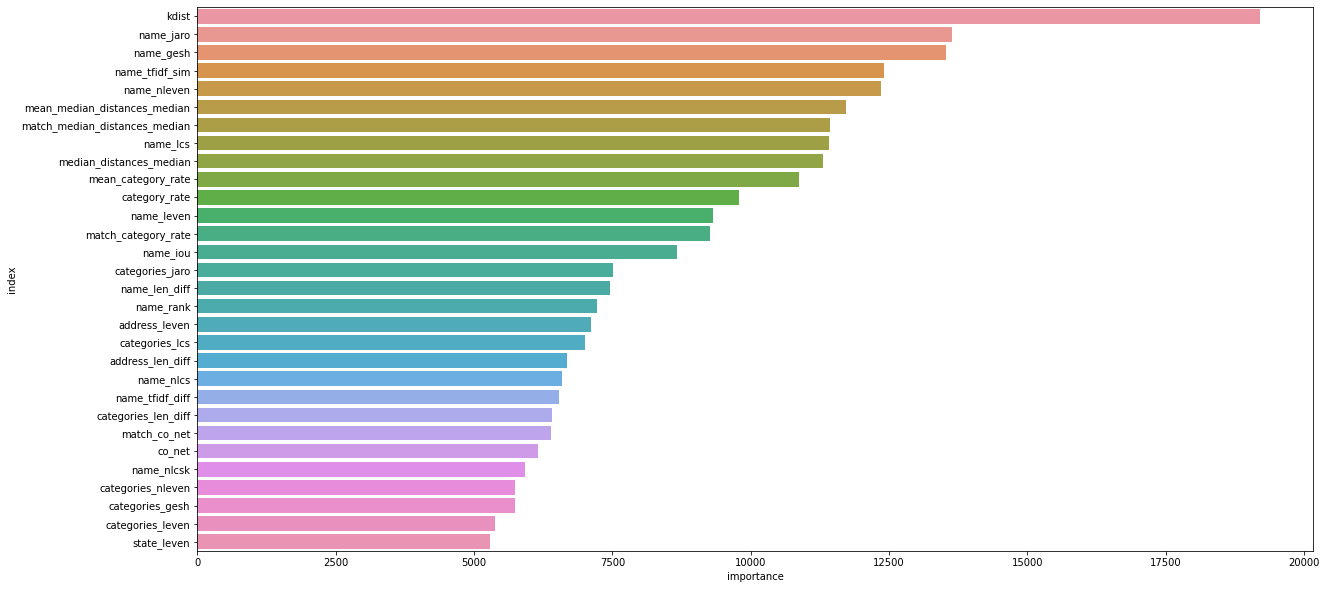

In [ ]:
importance_df = pd.DataFrame(models[0].feature_importances_, 
                             index=features, 
                             columns=['importance'])\
                    .sort_values("importance", ascending=False)


plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="index", data=importance_df.head(30).reset_index(drop=False))
plt.show()

In [ ]:
del train_X, train_y, valid_X, valid_y, models

# Change Submission Format

In [ ]:
tmp = train[['id', 'match_id', 'label']]
tmp[['pred_0', 'pred_1']] = oof

In [ ]:
tmp.to_csv(os.path.join(OUTPUT_PATH, 'oof.csv'), index = False)

### memoryリセットかけた

In [ ]:
oof = pd.read_csv(os.path.join(OUTPUT_PATH, 'oof.csv'))
oof.head()

,id,match_id,label,pred_0,pred_1
0,E_000002eae2a589,E_000002eae2a589,1,0.000034,0.999966
1,E_000007f24ebc95,E_000007f24ebc95,1,0.000024,0.999976
2,E_000008a8ba4f48,E_000008a8ba4f48,1,0.000017,0.999983
3,E_00001d92066153,E_00001d92066153,1,0.000010,0.999990
4,E_000023d8f4be44,E_000023d8f4be44,1,0.000009,0.999991


In [ ]:
y_true = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))[['id', 'point_of_interest']]
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(y_true)
poi2ids = get_poi2ids(y_true)
del y_true

In [ ]:
ids = list(oof.id.unique())
oof_pred = {
   id_x: [id_x] for id_x in ids
}

for idx, row in tqdm(oof.iterrows()):
    if row['pred_0'] < row['pred_1']:
        oof_pred[row['id']].append(row['match_id'])



0it [00:00, ?it/s]

In [ ]:
scores = []
for id_x in tqdm(ids):
    preds = set(oof_pred[id_x])
    targets = poi2ids[id2poi[id_x]]
    score = len((targets & preds)) / len((targets | preds))
    scores.append(score)
print('cv score is', np.array(scores).mean())
# 0.8643
# 0.8655

  0%|          | 0/1138812 [00:00<?, ?it/s]

cv score is 0.8534096732484279


# Check Misclassification 

In [ ]:
oof['pred'] = oof['pred_1'].round()
tmp = oof[['id', 'match_id', 'label', 'pred', 'pred_1']]

In [ ]:
t = tmp[tmp['label']!=tmp['pred']]
tt = t[t['pred_1']<0.2]

In [ ]:
len(t)

379721

In [ ]:
tt

,id,match_id,label,pred,pred_1
1856,E_00dcbf399a3c66,E_ef1d541a9820c6,1,0.0,0.000744
4461,E_020e76b9a1aadf,E_87b27e28040119,1,0.0,0.038479
5397,E_0280eae9180255,E_f82a0225911ce9,1,0.0,0.074528
9905,E_04852c224633d4,E_ef1d541a9820c6,1,0.0,0.000704
20058,E_090faf5df05cd9,E_e015d56f0b43e4,1,0.0,0.155966
...,...,...,...,...,...
9694159,E_fa4732f68460d2,E_d9193595ea8e3c,1,0.0,0.090446
9694286,E_fc11151815da25,E_3fc075be59541d,1,0.0,0.073187
9694390,E_fd5c3bd91664ad,E_fb56e371f8ffbb,1,0.0,0.139842
9694423,E_fda65393484426,E_0f0a31869ba481,1,0.0,0.058313


In [ ]:
id = 'E_0146e712d66bb8'
m_id = 'E_512009c07275bc'
ids = [id, m_id]
data[data.index.isin(ids)]
# data[data.id.isin(ids)]

,name,latitude,longitude,address,city,state,zip,country,url,phone,...,state_split,cv,co_net,main_category,scale,adjacency_frequency,betweeness_centrality,clustering_coefficient,median_distances_median,category_rate
id,,,,,,,,,,,,,,,,,,,,,
E_0146e712d66bb8,guccitong ming nan shi yi dai yi bi yi yuan d...,38.415602,-95.925751,oe 1143 a 1143 ...,,KS,NaN,US,NaN,NaN,...,[KS],0.0,-1.0,Ethiopian Restaurants,0,NaN,NaN,NaN,0.0,0.00113
E_512009c07275bc,tan suo kun lun gao fang wan biao yi bi yi y...,38.415602,-95.925751,lh 1143 88 8 ...,,KS,NaN,US,NaN,NaN,...,[KS],0.0,-1.0,Ethiopian Restaurants,0,NaN,NaN,NaN,0.0,0.00113


In [ ]:
train[(train['id']==id) & (train['match_id']==m_id)][['kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven']]

,kdist,categories_jaro,name_jaro,categories_lcs,name_tfidf_sim,name_leven,name_nleven


In [ ]:
train.name_lcs.min()

0

In [ ]:
train[
    (train['kdist']==0.0) &
    (train['categories_jaro']==1.0) & 
    (train['name_jaro']==1.0) & 
    (train['label']==0)
][['id', 'match_id', 'kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven', 'label']]

,id,match_id,kdist,categories_jaro,name_jaro,categories_lcs,name_tfidf_sim,name_leven,name_nleven,label
8561,E_01f222b0730b7d,E_6a98f7cd2f1edc,0.0,1.0,1.0,32.0,1.0,0,0.0,0
229254,E_33731081654e43,E_da15dd86bc3abf,0.0,1.0,1.0,11.0,1.0,0,0.0,0
248411,E_37c016139bbce5,E_e20aa8020ede08,0.0,1.0,1.0,15.0,1.0,0,0.0,0
272059,E_3d173cf36ea045,E_5fdb53e0f88509,0.0,1.0,1.0,46.0,1.0,0,0.0,0
375983,E_547b44a8dc4cb2,E_e33847f0d8fe8b,0.0,1.0,1.0,46.0,1.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...
549676,E_7b8b02381654e7,E_277ced0d491b95,0.0,1.0,1.0,5.0,1.0,0,0.0,0
735410,E_a534324f5cee01,E_9f2c4360daa6b0,0.0,1.0,1.0,5.0,1.0,0,0.0,0
741876,E_a6ac1d78e8ccb8,E_a9836ce1f2fda4,0.0,1.0,1.0,5.0,1.0,0,0.0,0
903495,E_caf447b497ce4e,E_bc14a8427db6be,0.0,1.0,1.0,5.0,1.0,0,0.0,0


In [ ]:
train[
    (train['kdist']==0.0) &
    (train['categories_jaro']==1.0) & 
    (train['name_jaro']==1.0) & 
    (train['label']==1)
][['id', 'match_id', 'kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven', 'label']]

,id,match_id,kdist,categories_jaro,name_jaro,categories_lcs,name_tfidf_sim,name_leven,name_nleven,label
1,E_000002eae2a589,E_000002eae2a589,0.0,1.0,1.0,21.0,1.0,0,0.0,1
2,E_000007f24ebc95,E_000007f24ebc95,0.0,1.0,1.0,20.0,1.0,0,0.0,1
3,E_000008a8ba4f48,E_000008a8ba4f48,0.0,1.0,1.0,18.0,1.0,0,0.0,1
4,E_00001d92066153,E_00001d92066153,0.0,1.0,1.0,19.0,1.0,0,0.0,1
5,E_000023d8f4be44,E_000023d8f4be44,0.0,1.0,1.0,4.0,1.0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
18764,E_043816eb4bd458,E_043816eb4bd458,0.0,1.0,1.0,21.0,1.0,0,0.0,1
84956,E_1307347ba588f3,E_1307347ba588f3,0.0,1.0,1.0,21.0,1.0,0,0.0,1
25384,E_05aff53ddd7f6c,E_05aff53ddd7f6c,0.0,1.0,1.0,21.0,1.0,0,0.0,1
38215,E_0892aa72e03d07,E_0892aa72e03d07,0.0,1.0,1.0,21.0,1.0,0,0.0,1


In [ ]:
train.head(20)[['id', 'match_id', 'kdist', 'categories_jaro', 'name_jaro', 'categories_lcs', 'name_tfidf_sim', 'name_leven', 'name_nleven', 'label']]

,id,match_id,kdist,categories_jaro,name_jaro,categories_lcs,name_tfidf_sim,name_leven,name_nleven,label
1,E_000002eae2a589,E_000002eae2a589,0.0,1.0,1.0,21.0,1.0,0,0.0,1
2,E_000007f24ebc95,E_000007f24ebc95,0.0,1.0,1.0,20.0,1.0,0,0.0,1
3,E_000008a8ba4f48,E_000008a8ba4f48,0.0,1.0,1.0,18.0,1.0,0,0.0,1
4,E_00001d92066153,E_00001d92066153,0.0,1.0,1.0,19.0,1.0,0,0.0,1
5,E_000023d8f4be44,E_000023d8f4be44,0.0,1.0,1.0,4.0,1.0,0,0.0,1
6,E_00002a131a2bf6,E_00002a131a2bf6,0.0,1.0,1.0,17.0,1.0,0,0.0,1
7,E_0000764d65557e,E_0000764d65557e,0.0,1.0,1.0,21.0,1.0,0,0.0,1
8,E_00007dcd2bb53f,E_00007dcd2bb53f,0.0,1.0,1.0,15.0,1.0,0,0.0,1
9,E_0000890af22ff5,E_0000890af22ff5,0.0,1.0,1.0,12.0,1.0,0,0.0,1
14,E_0000f17c539685,E_0000f17c539685,0.0,1.0,1.0,10.0,1.0,0,0.0,1


In [ ]:
# cols = ['kdist_country', 'kdist', 'categories_jaro', 'name_jaro']
# train[(train['id']==id) & (train['match_id']==m_id)][cols]

In [ ]:
# train[train['kdist_country']== train['kdist']]

In [ ]:
# data[data.index.isin(ids)].loc['E_34199c1154c0d9']['name'].split()

In [ ]:
# data[data.index.isin(ids)].loc['E_0258802b17b98e']['name'].split()